In [4]:
import pandas_gbq
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
import pickle
import h5py
warnings.filterwarnings("ignore")

In [5]:
with open('../../../app/SQL/Query_traer_clientes_simplificado.sql') as file:
    query=file.read()
data=pandas_gbq.read_gbq(query, project_id='customer-experience-384423',progress_bar_type=None)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250209 entries, 0 to 250208
Data columns (total 78 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id_cliente                         250209 non-null  Int64  
 1   promedio_compra                    250209 non-null  float64
 2   cantidad_compras                   250209 non-null  Int64  
 3   dropsize                           250209 non-null  float64
 4   contactable                        250209 non-null  Int64  
 5   compro_en_OUTLET                   250209 non-null  Int64  
 6   compro_en_ESTELAR                  250209 non-null  Int64  
 7   compro_en_MOVIES                   250209 non-null  Int64  
 8   compro_en_LITTLE_MIC               250209 non-null  Int64  
 9   compro_en_MOVIES_W                 250209 non-null  Int64  
 10  compro_en_OUTLET_MIC               250209 non-null  Int64  
 11  compro_en_EVENTOS                  2502

In [7]:
data.describe()

,id_cliente,promedio_compra,cantidad_compras,dropsize,contactable,compro_en_OUTLET,compro_en_ESTELAR,compro_en_MOVIES,compro_en_LITTLE_MIC,compro_en_MOVIES_W,...,compro_en_ZONA_4,compro_en_ZONA_5,compro_en_ZONA_6,compro_en_ZONA_7,compro_en_ZONA_M,compro_en_ECUADOR,compras_2018,compras_2019,compras_2020,compras_2021
count,250209.0,2.502090e+05,250209.0,2.502090e+05,250209.0,250209.0,250209.0,250209.0,250209.0,250209.0,...,250209.0,250209.0,250209.0,250209.0,250209.0,250209.0,8.375000e+03,1.600100e+04,4.145100e+04,1.229280e+05
mean,125105.999996,7.746694e+16,4.189805,3.043208e+16,0.579476,0.0,0.0,0.0,0.846197,0.0,...,0.181452,0.086716,0.153843,0.103885,0.0,0.0,3.127884e+05,3.400870e+05,2.758118e+18,4.426974e+05
std,72229.261096,5.908390e+17,14.888362,3.181584e+17,0.493644,0.0,0.0,0.0,0.360761,0.0,...,0.385393,0.281418,0.360799,0.305112,0.0,0.0,8.146475e+05,1.768256e+06,9.693510e+18,1.760022e+06
min,1.0,-4.644237e+05,1.0,-3.505040e+05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5.312610e+05,-3.240320e+05,-7.352690e+05,-2.136349e+07
25%,62554.0,4.293500e+04,1.0,1.824268e+04,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.193300e+04,4.699200e+04,5.285700e+04,5.453800e+04
50%,125106.0,6.561740e+04,2.0,2.814700e+04,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.021840e+05,1.156310e+05,1.895170e+05,1.523190e+05
75%,187658.0,1.058650e+05,5.0,4.074800e+04,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.765550e+05,3.024700e+05,1.352156e+06,4.033080e+05
max,250210.0,9.998460e+18,6803.0,9.908710e+18,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.822834e+07,1.905567e+08,4.019241e+20,3.226566e+08


In [8]:
data.drop(columns=['contactable'],inplace=True)

In [9]:
len(data)

250209

In [10]:
len(data[data['promedio_compra']<0])

464

In [11]:
len(data[data['promedio_compra']<0])*100/len(data)

0.18544496800674637

In [12]:
len(data[data['promedio_compra']>10586500])

8929

In [13]:
len(data[data['promedio_compra']>10586500])*100/len(data)

3.568616636491893

<Axes: >

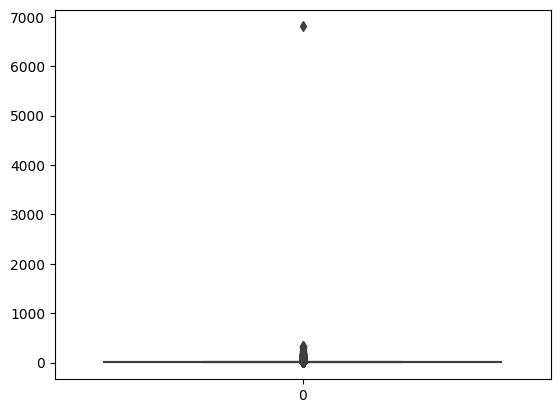

In [14]:
sns.boxplot(data['cantidad_compras'])

In [15]:
data_sin_outliers=data[(data['promedio_compra']<10586500) & (data['promedio_compra']>0)&(data['cantidad_compras']<6000)]

In [16]:
id_cliente=data_sin_outliers['id_cliente']
data_sin_outliers.drop(columns=['id_cliente'],inplace=True)

In [17]:
data_sin_outliers.fillna(0,inplace=True)

In [18]:
data_sin_outliers.describe()

,promedio_compra,cantidad_compras,dropsize,compro_en_OUTLET,compro_en_ESTELAR,compro_en_MOVIES,compro_en_LITTLE_MIC,compro_en_MOVIES_W,compro_en_OUTLET_MIC,compro_en_EVENTOS,...,compro_en_ZONA_4,compro_en_ZONA_5,compro_en_ZONA_6,compro_en_ZONA_7,compro_en_ZONA_M,compro_en_ECUADOR,compras_2018,compras_2019,compras_2020,compras_2021
count,2.403490e+05,240349.0,2.403490e+05,240349.0,240349.0,240349.0,240349.0,240349.0,240349.0,240349.0,...,240349.0,240349.0,240349.0,240349.0,240349.0,240349.0,2.403490e+05,2.403490e+05,2.403490e+05,2.403490e+05
mean,8.114793e+04,3.95851,2.969063e+04,0.0,0.0,0.0,0.869498,0.0,0.0,0.0,...,0.186766,0.089229,0.157979,0.106707,0.0,0.0,1.064062e+04,1.952317e+04,4.408835e+04,2.131038e+05
std,6.394818e+04,5.567132,1.630937e+04,0.0,0.0,0.0,0.336855,0.0,0.0,0.0,...,0.389724,0.285074,0.364722,0.308741,0.0,0.0,1.578202e+05,2.366071e+05,3.234980e+05,1.055253e+06
min,1.818989e-12,1.0,8.565878e-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.500840e+05,-6.432900e+04,-1.752080e+05,-7.590950e+05
25%,4.229400e+04,1.0,1.797556e+04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.331840e+04,2.0,2.742000e+04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.005620e+05,4.0,3.876500e+04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.477980e+05
max,2.212655e+06,343.0,3.465600e+05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.822834e+07,6.068646e+07,4.762578e+07,1.828241e+08


In [19]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_sin_outliers)
data_scaled = pd.DataFrame(data_scaled, columns=data_sin_outliers.columns)

In [20]:
data_scaled.describe()

,promedio_compra,cantidad_compras,dropsize,compro_en_OUTLET,compro_en_ESTELAR,compro_en_MOVIES,compro_en_LITTLE_MIC,compro_en_MOVIES_W,compro_en_OUTLET_MIC,compro_en_EVENTOS,...,compro_en_ZONA_4,compro_en_ZONA_5,compro_en_ZONA_6,compro_en_ZONA_7,compro_en_ZONA_M,compro_en_ECUADOR,compras_2018,compras_2019,compras_2020,compras_2021
count,240349.000000,240349.000000,240349.000000,240349.0,240349.0,240349.0,240349.000000,240349.0,240349.0,240349.0,...,240349.000000,240349.000000,240349.000000,240349.000000,240349.0,240349.0,240349.000000,240349.000000,240349.000000,240349.000000
mean,0.036674,0.008651,0.085672,0.0,0.0,0.0,0.869498,0.0,0.0,0.0,...,0.186766,0.089229,0.157979,0.106707,0.0,0.0,0.014110,0.001380,0.004588,0.005296
std,0.028901,0.016278,0.047061,0.0,0.0,0.0,0.336855,0.0,0.0,0.0,...,0.389724,0.285074,0.364722,0.308741,0.0,0.0,0.008541,0.003895,0.006768,0.005748
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.019115,0.000000,0.051869,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013534,0.001059,0.003665,0.004135
50%,0.028616,0.002924,0.079120,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013534,0.001059,0.003665,0.004135
75%,0.045449,0.008772,0.111857,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013534,0.001059,0.003665,0.004940
max,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000


In [21]:
filas_en_ceros=data_scaled.columns[data_scaled.sum()== 0].to_list()
data_scaled.drop(columns=filas_en_ceros,inplace=True)

In [22]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240349 entries, 0 to 240348
Data columns (total 43 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   promedio_compra                    240349 non-null  float64
 1   cantidad_compras                   240349 non-null  float64
 2   dropsize                           240349 non-null  float64
 3   compro_en_LITTLE_MIC               240349 non-null  float64
 4   compro_en_OUTLET_LITTLE_MIC        240349 non-null  float64
 5   dias_desde_ultima_compra_recencia  240349 non-null  float64
 6   PELUCHES                           240349 non-null  float64
 7   CALCETINES                         240349 non-null  float64
 8   PELUCHE                            240349 non-null  float64
 9   GAFAS                              240349 non-null  float64
 10  JUGUETERIA                         240349 non-null  float64
 11  SUECOS                             2403

<Axes: >

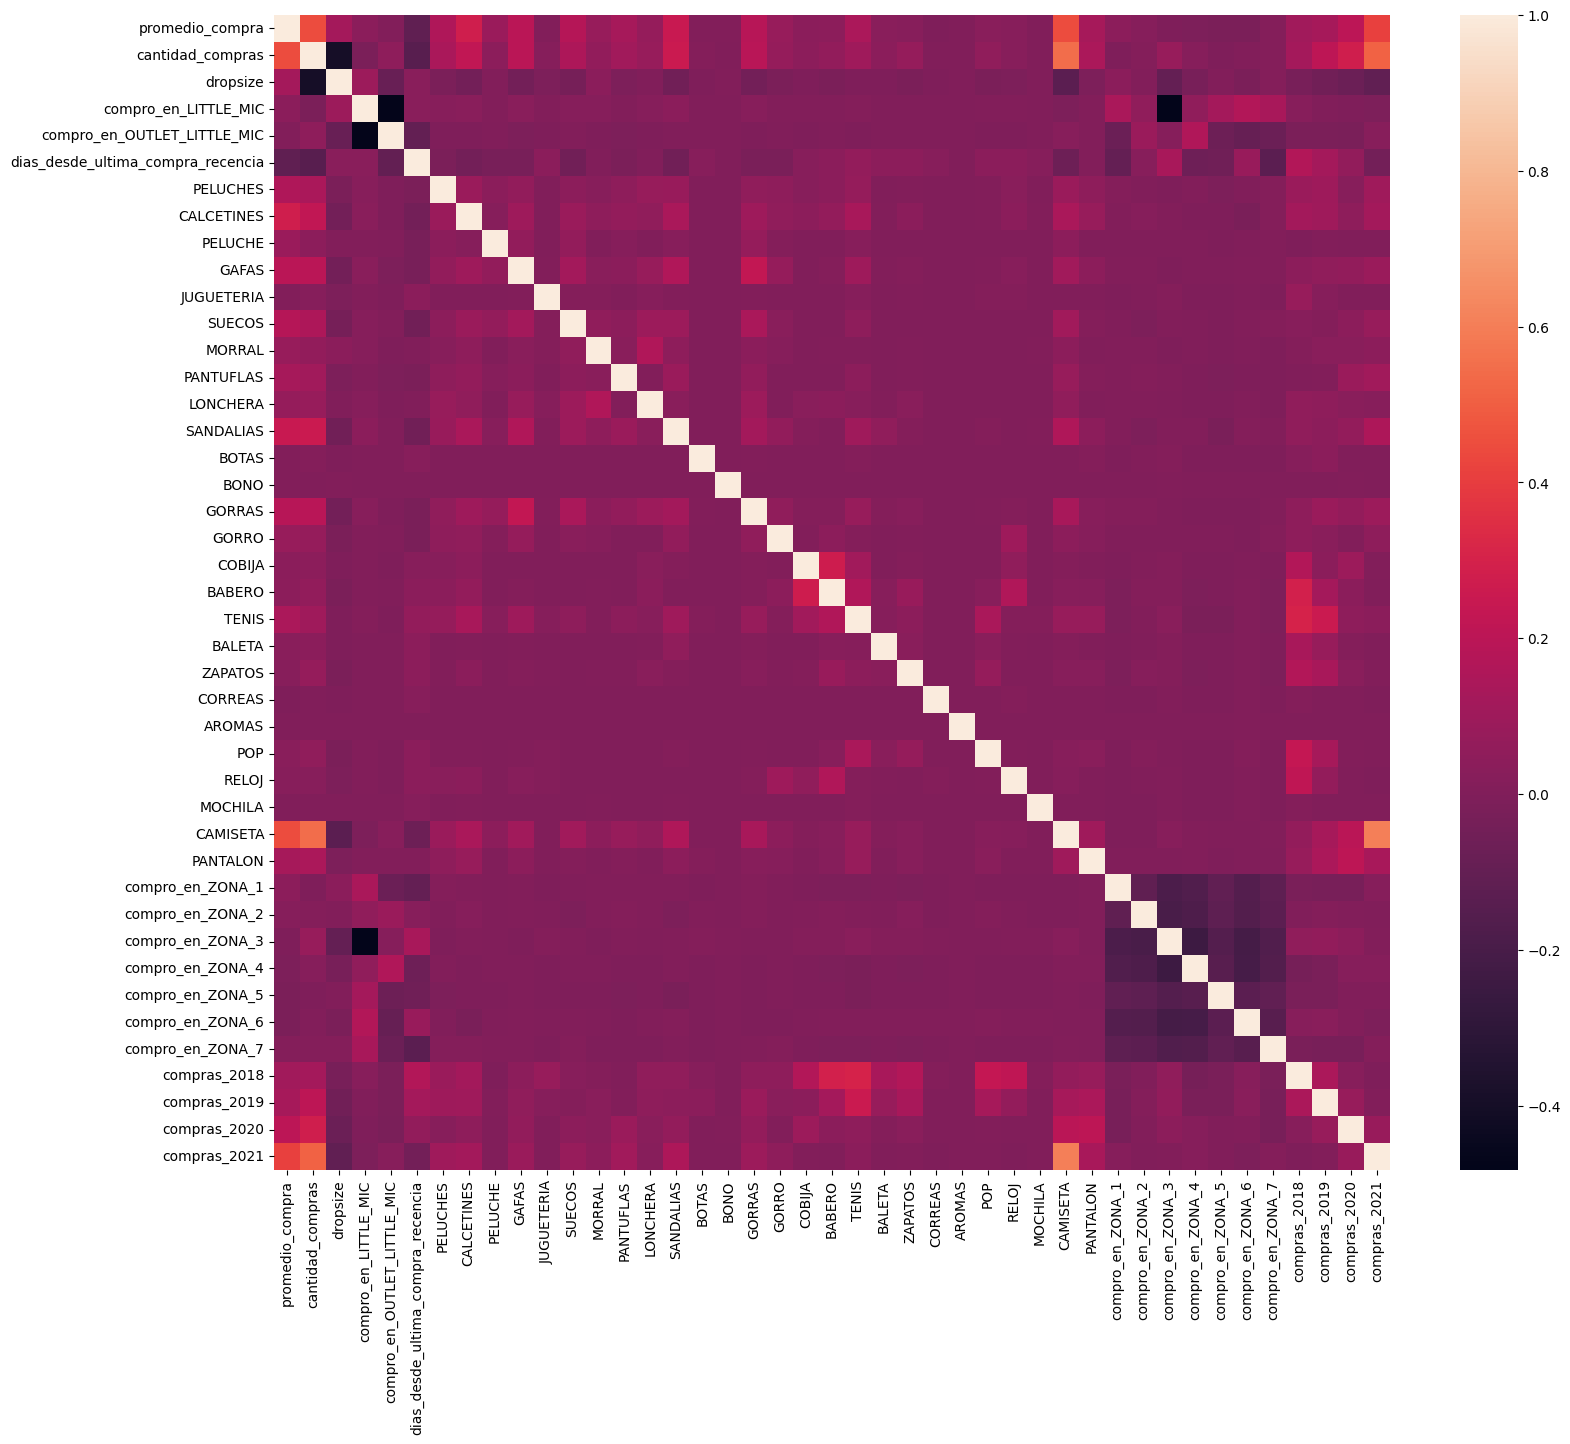

In [23]:
plt.figure(figsize=(18,15))
sns.heatmap(data=data_scaled.corr(), annot=False)

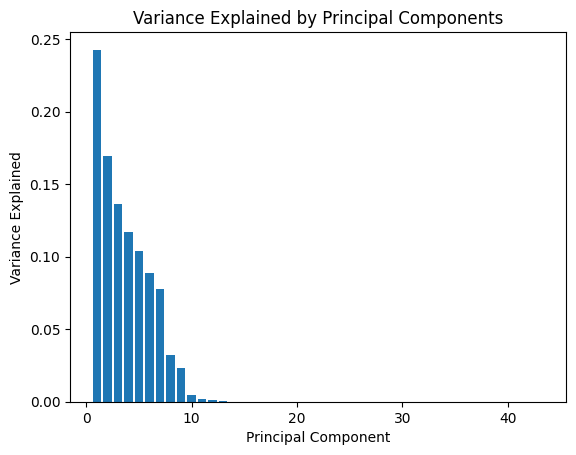

Explained Variance:
promedio_compra: 0.2427
cantidad_compras: 0.1692
dropsize: 0.1363
compro_en_LITTLE_MIC: 0.1171
compro_en_OUTLET_LITTLE_MIC: 0.1041
dias_desde_ultima_compra_recencia: 0.0890
PELUCHES: 0.0775
CALCETINES: 0.0323
PELUCHE: 0.0231
GAFAS: 0.0044
JUGUETERIA: 0.0020
SUECOS: 0.0009
MORRAL: 0.0002
PANTUFLAS: 0.0001
LONCHERA: 0.0001
SANDALIAS: 0.0001
BOTAS: 0.0001
BONO: 0.0001
GORRAS: 0.0001
GORRO: 0.0001
COBIJA: 0.0000
BABERO: 0.0000
TENIS: 0.0000
BALETA: 0.0000
ZAPATOS: 0.0000
CORREAS: 0.0000
AROMAS: 0.0000
POP: 0.0000
RELOJ: 0.0000
MOCHILA: 0.0000
CAMISETA: 0.0000
PANTALON: 0.0000
compro_en_ZONA_1: 0.0000
compro_en_ZONA_2: 0.0000
compro_en_ZONA_3: 0.0000
compro_en_ZONA_4: 0.0000
compro_en_ZONA_5: 0.0000
compro_en_ZONA_6: 0.0000
compro_en_ZONA_7: 0.0000
compras_2018: 0.0000
compras_2019: 0.0000
compras_2020: 0.0000
compras_2021: 0.0000


In [24]:
columns = data_scaled.columns

pca = PCA()
pca.fit(data_scaled)

# Get the variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Plot the variance explained
plt.bar(range(1, len(variance_explained) + 1), variance_explained)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.show()

# Create a dictionary with column names and their explained variance
explained_variance_dict = dict(zip(columns, variance_explained))

print("Explained Variance:")
for column, explained_variance in explained_variance_dict.items():
    print(f"{column}: {explained_variance:.4f}")

In [25]:
pca = PCA(n_components=5)
pca.fit(data_scaled)
data_pca=pca.transform(data_scaled)

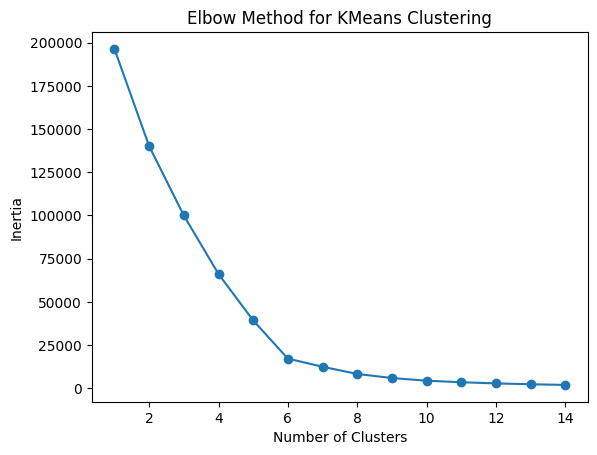

In [26]:
cluster_range = range(1, 15)  
inertias = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_pca)
    inertias.append(kmeans.inertia_)


plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

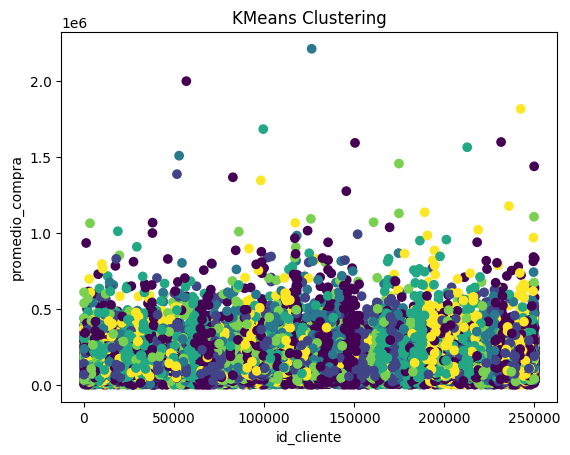

In [27]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(data_scaled)
labels = kmeans.labels_
plt.scatter(id_cliente, data_sin_outliers['promedio_compra'], c=labels) 
plt.xlabel('id_cliente')
plt.ylabel('promedio_compra')
plt.title('KMeans Clustering')
plt.show()

In [28]:
df_clusters = pd.DataFrame(kmeans.cluster_centers_, columns=data_scaled.columns).T

In [29]:
df_clusters

,0,1,2,3,4,5
promedio_compra,3.597121e-02,0.035707,4.017481e-02,3.611161e-02,3.756417e-02,3.615647e-02
cantidad_compras,9.212128e-03,0.008778,8.422333e-03,9.148974e-03,8.399854e-03,7.660498e-03
dropsize,8.111804e-02,0.084262,9.088996e-02,8.340553e-02,8.781662e-02,9.009033e-02
compro_en_LITTLE_MIC,5.547759e-01,1.000000,1.000000e+00,9.062066e-01,9.152991e-01,1.000000e+00
compro_en_OUTLET_LITTLE_MIC,5.313031e-02,0.000554,3.613239e-05,1.157517e-01,9.131816e-02,-6.800116e-16
dias_desde_ultima_compra_recencia,2.650733e-01,0.248160,1.562613e-01,1.842212e-01,2.264349e-01,1.554967e-01
PELUCHES,4.289685e-02,0.043023,4.324030e-02,4.308925e-02,4.299681e-02,4.296779e-02
CALCETINES,7.119769e-02,0.070281,7.117167e-02,7.090436e-02,7.159952e-02,7.108472e-02
PELUCHE,1.232488e-04,0.000135,1.726516e-04,1.148765e-04,1.573829e-04,1.341166e-04
GAFAS,3.086584e-02,0.031243,3.126936e-02,3.108777e-02,3.116779e-02,3.108147e-02


In [30]:

with open('../services/scaler-0.1.0.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [31]:
with h5py.File('../models/trained_model-0.1.0.h5', 'w') as file:
    file.create_dataset('cluster_centers_', data=kmeans.cluster_centers_)
    file.create_dataset('labels_', data=kmeans.labels_)
    file.create_dataset('inertia_', data=kmeans.inertia_)
    file.create_dataset('n_iter_', data=kmeans.n_iter_)